# Part 3-- Variational Autoencoder 

### Using code provided from Canvas

In [213]:
import tensorflow._api.v2.compat.v1 as tf 
tf.disable_v2_behavior()

In [214]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from keras.callbacks import LearningRateScheduler

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

In [216]:
m = 50   
n_z = 2
n_epoch = 10
epsilon_std=1.0


inputs = Input(shape=(784,))

h_q = Dense(512, activation='relu')(inputs)

mu = Dense(n_z, activation='linear')(h_q)

log_sigma = Dense(n_z, activation='linear')(h_q)

In [217]:
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z),mean=0., stddev=epsilon_std)
    return mu + K.exp(log_sigma / 2) * eps

In [218]:
z = Lambda(sample_z)([mu, log_sigma])

In [220]:
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')


h_p = decoder_hidden(z)
outputs = decoder_out(h_p)

Tensor("input_13:0", shape=(?, 784), dtype=float32)
Tensor("dense_70/Sigmoid:0", shape=(50, 784), dtype=float32)


In [221]:
vae = Model(inputs, outputs)


encoder = Model(inputs, mu)

d_in = Input(shape=(n_z,))

d_h = decoder_hidden(d_in)

d_out = decoder_out(d_h)

generator = Model(d_in, d_out)

In [256]:
def vae_loss(y_true, y_pred):

    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
    
    return recon + kl

In [223]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, y_test) = mnist.load_data()

In [224]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [225]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(x_train, x_train, batch_size=m, nb_epoch=n_epoch)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 145us/sample - loss: 485.3878
Epoch 2/10
60000/60000 [==============================] - 9s 144us/sample - loss: 430.2223
Epoch 3/10
60000/60000 [==============================] - 8s 137us/sample - loss: 428.0727
Epoch 4/10
60000/60000 [==============================] - 8s 126us/sample - loss: 427.4495
Epoch 5/10
60000/60000 [==============================] - 7s 122us/sample - loss: 427.4279
Epoch 6/10
60000/60000 [==============================] - 9s 153us/sample - loss: 427.4217
Epoch 7/10
60000/60000 [==============================] - 10s 162us/sample - loss: 427.4190
Epoch 8/10
60000/60000 [==============================] - 9s 146us/sample - loss: 427.4178
Epoch 9/10
60000/60000 [==============================] - 9s 148us/sample - loss: 427.4172
Epoch 10/10
60000/60000 [==============================] - 9s 148us/sample - loss: 427.4169


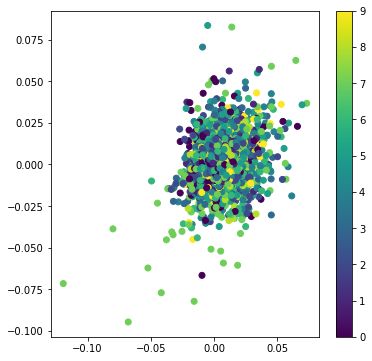

In [229]:
x_test_encoded = encoder.predict(x_test, batch_size=m)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

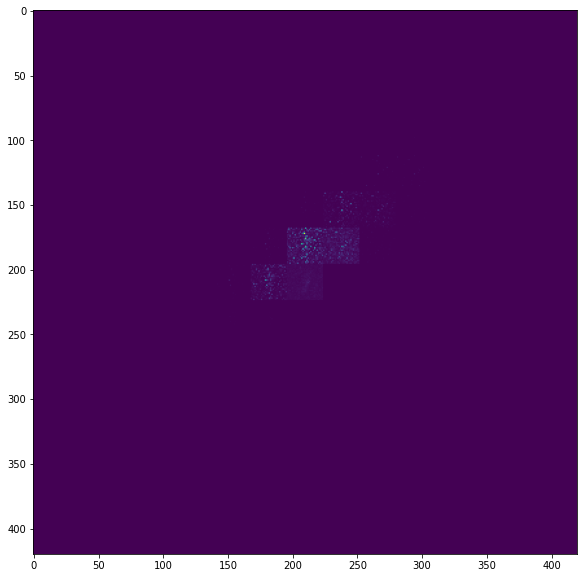

In [230]:
n = 15  # figure with 15x15 digits
digit_size = 28

figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 2.0
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()


For some reason this code is not producing good results, below is a version of a variational autoencoder 
from Aurélien Géron and his textbook Hands on Machine Learning with Scikit-Learn, Keras and Tensorflow 

# Part 3 -- Variational Autoencoder 2nd Version

In [202]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


# With one hidden layer 784--> 512 --> 2

In [258]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 2

inputs = keras.layers.Input(shape=[28, 28])

z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(512, activation="relu")(z)

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])

x = keras.layers.Dense(512, activation="relu")(decoder_inputs)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)

outputs = keras.layers.Reshape([28, 28])(x)

variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),axis=-1)

variational_ae.add_loss(K.mean(latent_loss) / 784.)

#variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
variational_ae.compile(loss="binary_crossentropy", optimizer="adam")

history = variational_ae.fit(X_train, X_train, epochs=10, batch_size=50,
                             validation_data=(X_valid, X_valid))


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
54850/55000 [============================>.] - ETA: 0s - loss: 0.2347

/usr/local/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


55000/55000 [==============================] - 12s 218us/sample - loss: 0.2347 - val_loss: 0.2135
Epoch 2/10
55000/55000 [==============================] - 10s 177us/sample - loss: 0.2115 - val_loss: 0.2078
Epoch 3/10
55000/55000 [==============================] - 10s 178us/sample - loss: 0.2073 - val_loss: 0.2038
Epoch 4/10
55000/55000 [==============================] - 10s 179us/sample - loss: 0.2042 - val_loss: 0.2014
Epoch 5/10
55000/55000 [==============================] - 10s 181us/sample - loss: 0.2019 - val_loss: 0.2000
Epoch 6/10
55000/55000 [==============================] - 10s 183us/sample - loss: 0.2002 - val_loss: 0.1988
Epoch 7/10
55000/55000 [==============================] - 10s 183us/sample - loss: 0.1990 - val_loss: 0.1974
Epoch 8/10
55000/55000 [==============================] - 10s 182us/sample - loss: 0.1979 - val_loss: 0.1972
Epoch 9/10
55000/55000 [==============================] - 10s 187us/sample - loss: 0.1971 - val_loss: 0.1960
Epoch 10/10
55000/55000 [=====

/usr/local/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


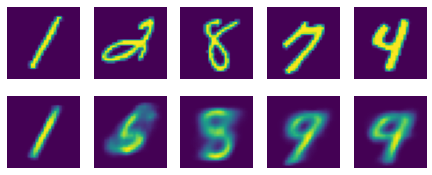

In [259]:
show_reconstructions(variational_ae)
plt.show()

# With two hidden layers 784-->512-->64-->2

In [253]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 2

inputs = keras.layers.Input(shape=[28, 28])

z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(512, activation="relu")(z)
z = keras.layers.Dense(64, activation="relu")(z)

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])

x = keras.layers.Dense(64, activation="relu")(decoder_inputs)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)

outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),axis=-1)

variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

history = variational_ae.fit(X_train, X_train, epochs=10, batch_size=50,
                             validation_data=(X_valid, X_valid))


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 15s 282us/sample - loss: 0.2248 - rounded_accuracy: 0.8906 - val_loss: 0.2071 - val_rounded_accuracy: 0.9018
Epoch 2/10
55000/55000 [==============================] - 17s 313us/sample - loss: 0.2031 - rounded_accuracy: 0.9055 - val_loss: 0.1984 - val_rounded_accuracy: 0.9096
Epoch 3/10
55000/55000 [==============================] - 21s 382us/sample - loss: 0.1971 - rounded_accuracy: 0.9102 - val_loss: 0.1932 - val_rounded_accuracy: 0.9131
Epoch 4/10
55000/55000 [==============================] - 15s 274us/sample - loss: 0.1936 - rounded_accuracy: 0.9129 - val_loss: 0.1907 - val_rounded_accuracy: 0.9150
Epoch 5/10
55000/55000 [==============================] - 14s 248us/sample - loss: 0.1910 - rounded_accuracy: 0.9150 - val_loss: 0.1887 - val_rounded_accuracy: 0.9168
Epoch 6/10
55000/55000 [==============================] - 15s 267us/sample - loss: 0.1890 - rounded_accuracy: 0.9164

In [232]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [236]:
def plot_image(image):
    plt.imshow(image)
    plt.axis("off")

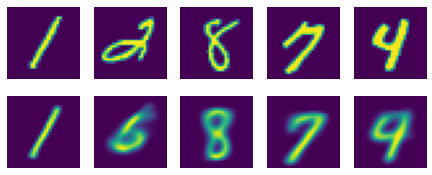

In [254]:
show_reconstructions(variational_ae)
plt.show()

The overall loss for the VAE with one hidden layer was around 19%. The overall loss for the VAE with two hidden layers was around 18%. There is not too much of a difference between the two, but there is a slight improvement with the second variation. 